In [45]:
import multiprocessing
import os
import psutil

logical_cpu_count = multiprocessing.cpu_count()
print(f"Total logical CPUs: {logical_cpu_count}")

try:
    allowed_cpu_count = len(os.sched_getaffinity(0))
    print(f"Allowed CPUs for the process: {allowed_cpu_count}")
except:
    allowed_cpu_count = psutil.cpu_count(logical=True)
    print(f"Allowed CPUs for the process: {allowed_cpu_count}")

Total logical CPUs: 12
Allowed CPUs for the process: 12


In [1]:
import scanpy as sc
sc.settings.n_jobs = 8
# import h5py
# import umap
import numpy as np
import pandas as pd
import seaborn as sns
import anndata as ad
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

Preprocessed UMAP data in MTX form comes from the following:
- [human liver samples](https://singlecell.broadinstitute.org/single_cell/study/SCP2154/identification-of-a-broadly-fibrogenic-macrophage-subset-induced-by-type-3-inflammation-human-liver-fibrosis-scrnaseq-atlas#/)
- [mouse liver samples](https://singlecell.broadinstitute.org/single_cell/study/SCP2053/identification-of-a-broadly-fibrogenic-macrophage-subset-induced-by-type-3-inflammation-murine-liver-fibrosis-scrnaseq-atlas?#study-summary )

In [2]:
# Load the filtered feature/cell matrix from HDF5
adata = sc.read_10x_mtx(
    "../data/SCP2154_human/expression/64130e92cc37d750c0a62f14",
    var_names="gene_symbols",  # uses 2nd column
    make_unique=True,
    cache=True,
)
adata.obs['sample'] = adata.obs.index
adata.obs
# barcodes = pd.read_csv("../data/SCP2154_human/expression/64130e92cc37d750c0a62f14//barcodes_raw.tsv")
# features = pd.read_csv(
#     "../data/SCP2154_human"/expression/64130e92cc37d750c0a62f14//features_raw.tsv"
# )

,sample
AAACCTGTCGGCGCTA_1_1,AAACCTGTCGGCGCTA_1_1
AAACGGGAGAAACCGC_1_1,AAACGGGAGAAACCGC_1_1
AAACGGGAGACGCAAC_1_1,AAACGGGAGACGCAAC_1_1
AAACGGGAGGGCTTCC_1_1,AAACGGGAGGGCTTCC_1_1
AAACGGGAGTCTCGGC_1_1,AAACGGGAGTCTCGGC_1_1
...,...
TTTGTCAGTGATAAAC-9_6,TTTGTCAGTGATAAAC-9_6
TTTGTCAGTGGCCCTA-9_6,TTTGTCAGTGGCCCTA-9_6
TTTGTCAGTTCCCGAG-9_6,TTTGTCAGTTCCCGAG-9_6
TTTGTCAGTTGTACAC-9_6,TTTGTCAGTTGTACAC-9_6


In [3]:
adata.layers["counts"] = adata.X.copy()

In [4]:
adata = adata

In [5]:
metadata = pd.read_csv("../data/SCP2154_human/metadata/2022_SI_human_liver_allcells_metadata_file.txt", sep="\t").set_index("NAME").iloc[1:,[1, 5]]
metadata

,donor_id,disease__ontology_label
NAME,,
AAACCTGTCGGCGCTA_1_1,norm1,normal
AAACGGGAGAAACCGC_1_1,norm1,normal
AAACGGGAGACGCAAC_1_1,norm1,normal
AAACGGGAGGGCTTCC_1_1,norm1,normal
AAACGGGAGTCTCGGC_1_1,norm1,normal
...,...,...
TTTGTCAGTGATAAAC-9_6,zhao9,normal
TTTGTCAGTGGCCCTA-9_6,zhao9,normal
TTTGTCAGTTCCCGAG-9_6,zhao9,normal


In [6]:
# Suppose adata.obs has a column 'cell_id' that matches df_to_add['cell_id']
adata.obs = adata.obs.merge(metadata, left_on='sample', right_on='NAME', how='left')
adata.obs

/opt/anaconda3/envs/scrna_env/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


,sample,donor_id,disease__ontology_label
0,AAACCTGTCGGCGCTA_1_1,norm1,normal
1,AAACGGGAGAAACCGC_1_1,norm1,normal
2,AAACGGGAGACGCAAC_1_1,norm1,normal
3,AAACGGGAGGGCTTCC_1_1,norm1,normal
4,AAACGGGAGTCTCGGC_1_1,norm1,normal
...,...,...,...
328778,TTTGTCAGTGATAAAC-9_6,zhao9,normal
328779,TTTGTCAGTGGCCCTA-9_6,zhao9,normal
328780,TTTGTCAGTTCCCGAG-9_6,zhao9,normal
328781,TTTGTCAGTTGTACAC-9_6,zhao9,normal


In [7]:
adata.var.index[adata.var.index.str.contains("MIR122HG")]

Index(['MIR122HG'], dtype='object')

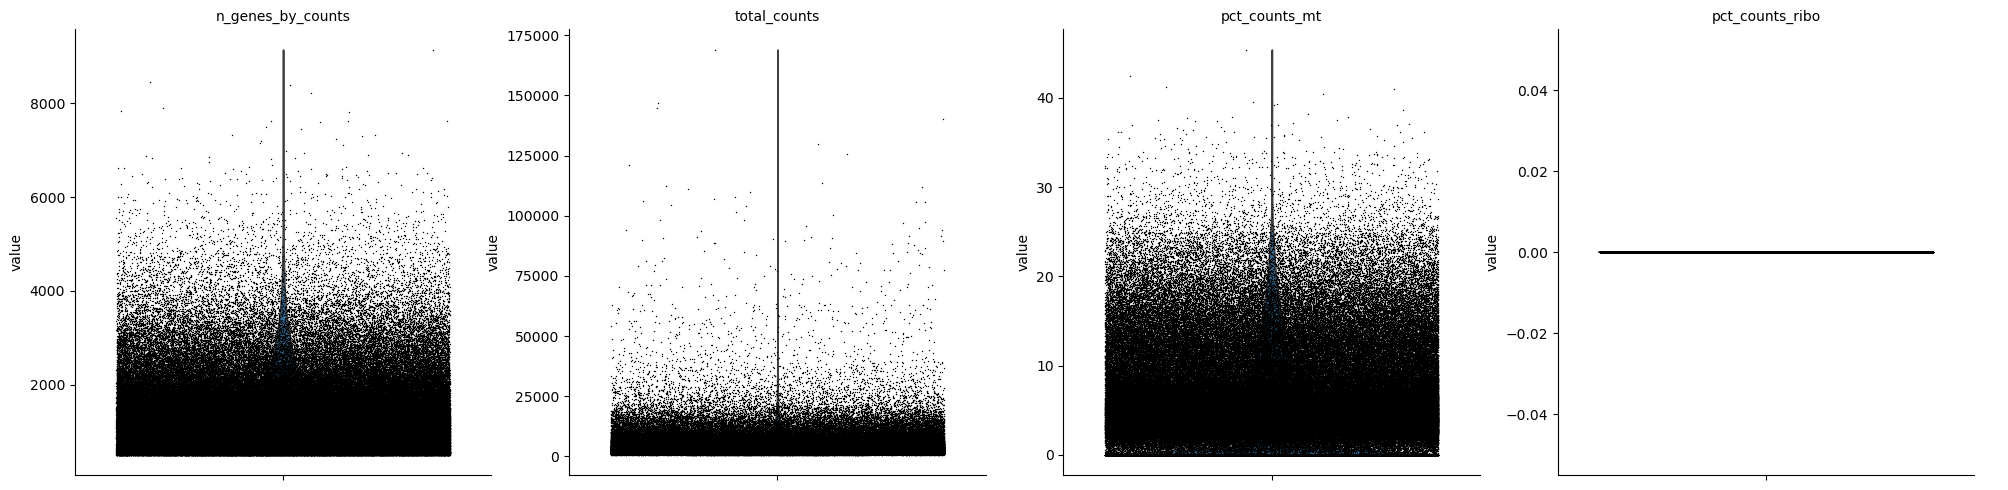

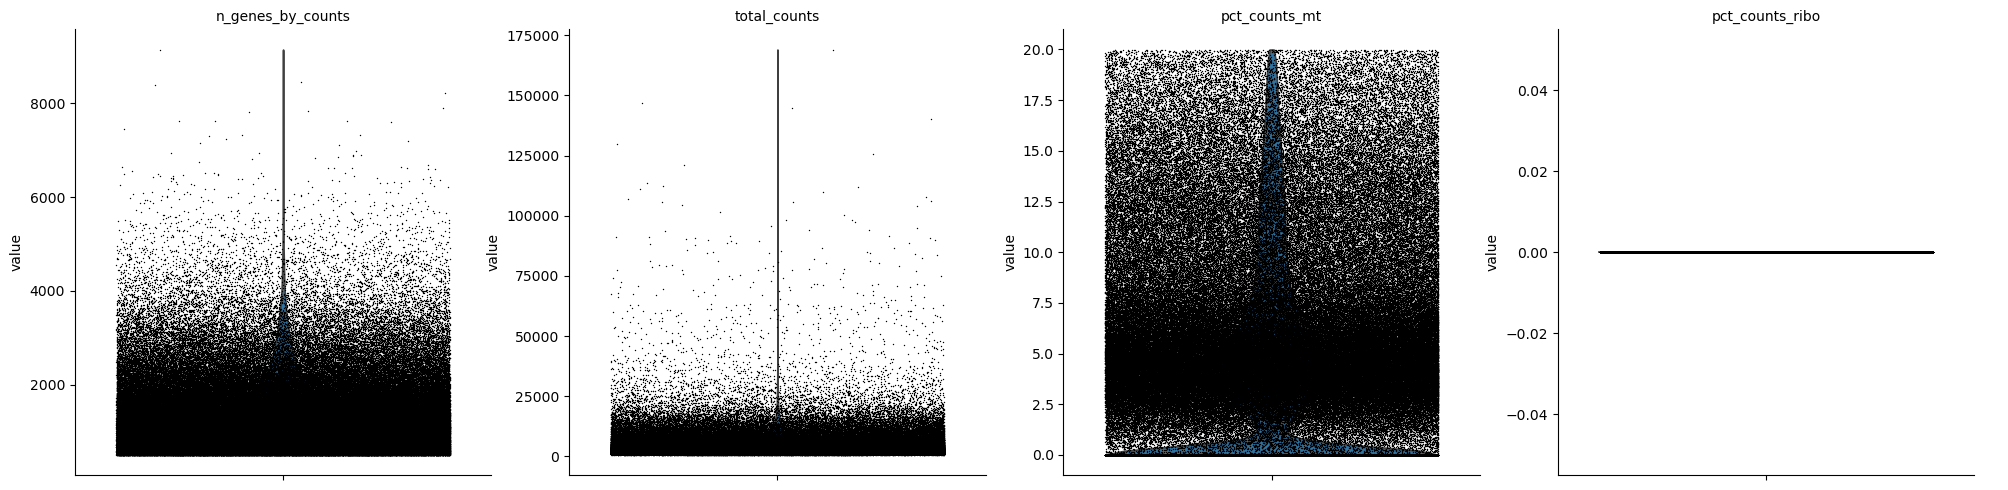

/opt/anaconda3/envs/scrna_env/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [8]:
# mitochondrial genes, MT for human Mt for mice
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', "ribo"], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(
adata,
["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
jitter=0.4,
multi_panel=True,
)

adata = adata[adata.obs.pct_counts_mt < 20]
adata = adata[adata.obs.pct_counts_ribo < 1]

sc.pl.violin(
adata,
["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
jitter=0.4,
multi_panel=True,
)

sc.pp.filter_cells(adata, min_genes=200) 
sc.pp.filter_genes(adata, min_cells=3) 

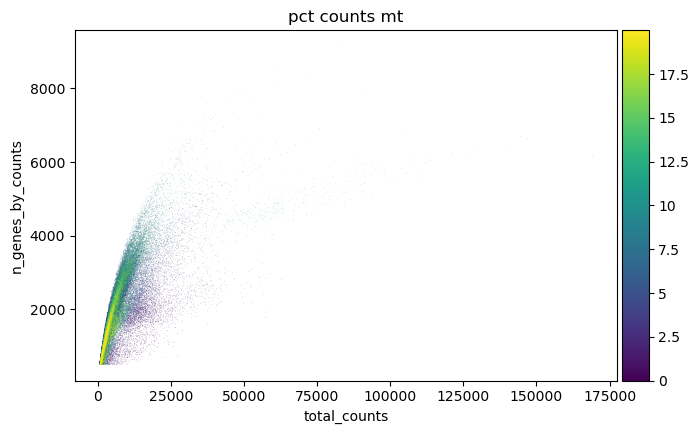

In [9]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [10]:
sc.pp.scrublet(adata, batch_key="donor_id") #can be configured to factor in batches

# normalize
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
sc.pp.scale(adata, max_value=50)

/opt/anaconda3/envs/scrna_env/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [ ]:
# Scale the data and perform PCA
sc.tl.pca(adata, svd_solver='arpack')

: 

: 

: 

In [ ]:
sc.pl.pca(adata)

In [ ]:
key = "n50_pc15"
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=15, key_added=key)

# # Plot UMAP
sc.tl.leiden(adata, flavor="igraph", resolution=0.8, key_added=f"leiden_res0.8_{key}", neighbors_key=key)
sc.tl.umap(adata, neighbors_key=key)
sc.pl.umap(adata, legend_loc="on data", color=[f"leiden_res0.8_{key}"])
# ---------------------------- Mouse Data Settings --------------------------- #
# key = "n21_pc31"
# resolution = 0.75
# leidan_key = f"leiden_res{resolution}_{key}"
# # Compute neighborhood graph
# sc.pp.neighbors(adata, n_neighbors=21, n_pcs=31, key_added=key)

# # Plot UMAP
# sc.tl.leiden(adata, flavor="igraph", resolution=0.75, key_added=leidan_key, neighbors_key=key)
# sc.tl.umap(adata, neighbors_key=key)
# sc.pl.umap(adata, legend_loc="on data", color=[leidan_key])

/home/hjang620/miniconda3/envs/scrna_env/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [1]:
sc.pl.umap(adata, color=["Alb", "Apoa2", "Ass1", "Pck1"], frameon=False, vmax=10)

NameError: name 'sc' is not defined

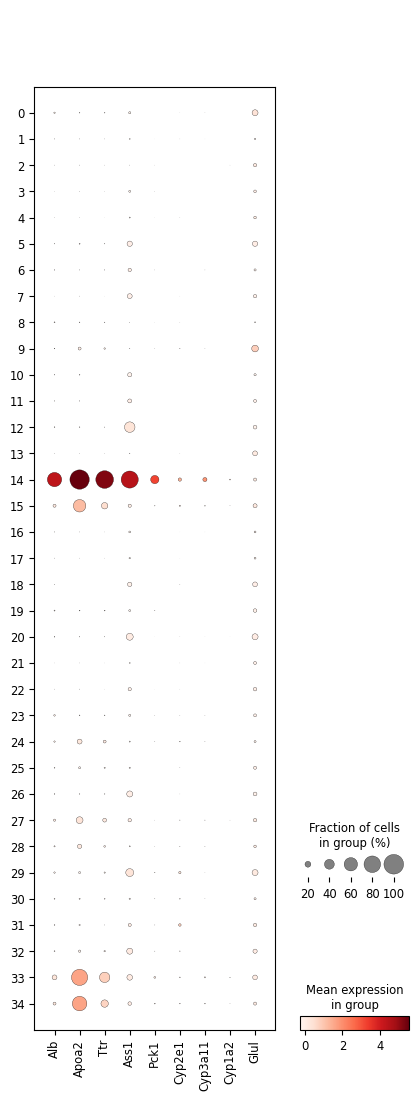

In [223]:
sc.pl.dotplot(adata, ['Alb', 'Apoa2', 'Ttr', 'Ass1', 'Pck1', 'Cyp2e1', 'Cyp3a11', 'Cyp1a2', 'Glul'], groupby=leidan_key)

In [224]:
sc.tl.rank_genes_groups(adata, groupby=leidan_key, method="t-test")
# print(adata.obs.columns)

/home/hjang620/miniconda3/envs/scrna_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/hjang620/miniconda3/envs/scrna_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/hjang620/miniconda3/envs/scrna_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/hjang620/miniconda3/envs/scrna_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/hjang620/miniconda3/envs/scrna_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value enco

In [227]:
sc.get.rank_genes_groups_df(adata, group="14").head(20)

,names,scores,logfoldchanges,pvals,pvals_adj
0,Dbi,203.906555,NaN,0.0,0.0
1,Fabp1,176.845581,NaN,0.0,0.0
2,Apoc1,153.509872,NaN,0.0,0.0
3,Scp2,147.731567,NaN,0.0,0.0
4,Prdx1,138.604630,NaN,0.0,0.0
5,Apoa2,129.736511,NaN,0.0,0.0
6,Ftl1,118.406403,NaN,0.0,0.0
7,Cyb5a,105.170898,NaN,0.0,0.0
8,Bhmt,104.538826,NaN,0.0,0.0
9,Wfdc21,97.112556,NaN,0.0,0.0


In [228]:
# there seems to be a lot of contamination or smth but group 14 is the closest match for hepatocyte
# Create a new AnnData object with only cluster 14 cells
hepatocytes = adata[adata.obs[leidan_key] == '14'].copy()

In [229]:
hepatocytes.shape  # (n_cells, n_genes)

(1936, 19688)

In [243]:
pbs = []
for batch in hepatocytes.obs.batch.unique():
    samp_hepatocytes = hepatocytes[hepatocytes.obs['batch'] == batch]
    samp_hepatocytes.X = samp_hepatocytes.layers['counts'] #make sure to use raw data
    
    X_sum = samp_hepatocytes.X.sum(axis=0)
    X_sum = np.asarray(X_sum).reshape(1, -1) 
    
    rep_adata = sc.AnnData(X_sum, var = samp_hepatocytes.var[[]])
    rep_adata
    rep_adata.obs_names = [batch]
    rep_adata.obs['disease_model'] = samp_hepatocytes.obs['disease_model'].iloc[0]
    pbs.append(rep_adata)

/tmp/ipykernel_189705/2255189069.py:4: UserWarning: Trying to set a dense array with a sparse array on a view.Densifying the sparse array.This may incur excessive memory usage
  samp_hepatocytes.X = samp_hepatocytes.layers['counts'] #make sure to use raw data
/tmp/ipykernel_189705/2255189069.py:4: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  samp_hepatocytes.X = samp_hepatocytes.layers['counts'] #make sure to use raw data
/tmp/ipykernel_189705/2255189069.py:4: UserWarning: Trying to set a dense array with a sparse array on a view.Densifying the sparse array.This may incur excessive memory usage
  samp_hepatocytes.X = samp_hepatocytes.layers['counts'] #make sure to use raw data
/tmp/ipykernel_189705/2255189069.py:4: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  samp_hepatocytes.X = samp_hepatocytes.layers['counts'] #make sure to use raw data
/tmp/ipykernel_189705/2255189069.py:4: UserWarning: Trying to 

In [244]:
pbs

[AnnData object with n_obs × n_vars = 1 × 19688
     obs: 'disease_model',
 AnnData object with n_obs × n_vars = 1 × 19688
     obs: 'disease_model',
 AnnData object with n_obs × n_vars = 1 × 19688
     obs: 'disease_model',
 AnnData object with n_obs × n_vars = 1 × 19688
     obs: 'disease_model',
 AnnData object with n_obs × n_vars = 1 × 19688
     obs: 'disease_model',
 AnnData object with n_obs × n_vars = 1 × 19688
     obs: 'disease_model']

In [245]:
hepatocytes = sc.concat(pbs)

In [ ]:
# can take a looksie at the subclustering in group 14 if u wish
# sc.pp.normalize_total(hepatocytes)
# sc.pp.log1p(hepatocytes)
# sc.pp.pca(hepatocytes)
# sc.pp.neighbors(hepatocytes)
# sc.tl.leiden(hepatocytes, resolution=0.5)
# sc.tl.umap(hepatocytes)
# sc.pl.umap(hepatocytes, color=[leidan_key, 'Pck1', 'Cyp2e1', 'Glul'])

In [251]:
counts = pd.DataFrame(hepatocytes.X, columns = hepatocytes.var_names)
dds = DeseqDataSet(
    counts = counts,
    metadata=hepatocytes.obs,
    design_factors="disease_model")
dds

/tmp/ipykernel_189705/911441864.py:2: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


AnnData object with n_obs × n_vars = 6 × 19688
    obs: 'disease_model'
    obsm: 'design_matrix'

In [252]:
sc.pp.filter_genes(dds, min_cells = 1)
dds

AnnData object with n_obs × n_vars = 6 × 13988
    obs: 'disease_model'
    var: 'n_cells'
    obsm: 'design_matrix'

In [253]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.87 seconds.

Fitting dispersion trend curve...
/home/hjang620/miniconda3/envs/scrna_env/lib/python3.13/site-packages/pydeseq2/dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.17 seconds.

/home/hjang620/miniconda3/envs/scrna_env/lib/python3.13/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.09 seconds.

Fitting LFCs...
... done in 0.85 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.



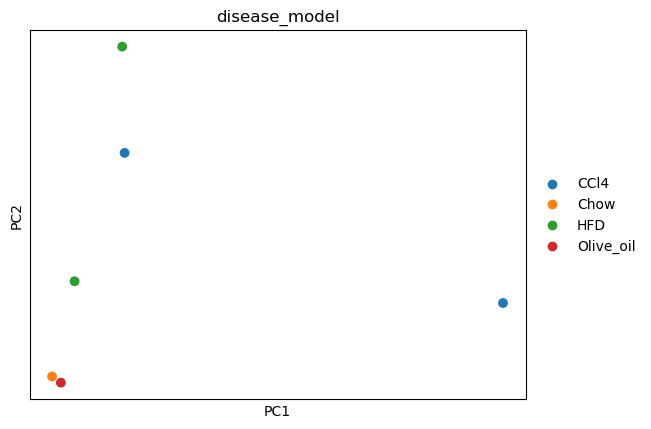

In [255]:
sc.tl.pca(dds)
sc.pl.pca(dds, color = 'disease_model', size = 200)

In [256]:
stat_res = DeseqStats(dds, n_cpus=8, contrast=('disease_model', 'HFD', 'Chow'))
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: disease_model HFD vs Chow
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Sox17     0.018739       -2.349406  6.948537 -0.338115  0.735276  0.989101
Mrpl15   39.963777        1.294921  1.218672  1.062568  0.287978  0.989101
Lypla1   41.275759       -0.118799  0.972089 -0.122210  0.902733  0.989101
Tcea1    17.778219        1.315583  1.371373  0.959318  0.337398  0.989101
Atp6v1h  10.311063       -1.892478  1.332709 -1.420024  0.155601  0.989101
...            ...             ...       ...       ...       ...       ...
Dpcd      2.924685       -2.349443  6.650597 -0.353268  0.723888  0.989101
Tmem180   0.056216       -2.349412  6.948529 -0.338116  0.735275  0.989101
Obfc1     0.375037       -2.349426  6.716998 -0.349773  0.726509  0.989101
PISD      1.462408       -2.349437  6.653080 -0.353135  0.723987  0.989101
DHRSX     0.806291       -2.349433  6.667396 -0.352376  0.724556  0.989101

[13988 rows x 6 columns]


... done in 15.80 seconds.



In [266]:
de  = stat_res.results_df
de.sort_values('stat', ascending = False)
de.index[de.index.str.contains("Mir")]

Index(['Mir17hg', 'Mir142hg', 'Mir155hg', 'Mirt1'], dtype='object')